## Analyze sports facilities near given location to determine location for building new sports facility

In [1]:
import pandas as pd
import numpy as np
import json
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import DBSCAN 
import matplotlib.pyplot as plt 
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.preprocessing import StandardScaler 
from mpl_toolkits.basemap import Basemap
from pylab import rcParams
%matplotlib inline

In [2]:
!conda install -c conda-forge basemap-data-hires -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - basemap-data-hires


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    basemap-data-hires-1.2.0   |                0       105.4 MB  conda-forge

The following NEW packages will be INSTALLED:

    basemap-data-hires: 1.2.0-0 conda-forge


basemap-data-hires-1 | 105.4 MB  | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [3]:
CLIENT_ID = 'FY0DZWHO3Z5K0YN5B0ZISGS5Q24G3V2SF3JPHZQ5B0541ZUL' # your Foursquare ID
CLIENT_SECRET = '45IIU3AKQ0JUE42SZW0AAFQV2UAOOP3SODTHSUKO4US5Z0A2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FY0DZWHO3Z5K0YN5B0ZISGS5Q24G3V2SF3JPHZQ5B0541ZUL
CLIENT_SECRET:45IIU3AKQ0JUE42SZW0AAFQV2UAOOP3SODTHSUKO4US5Z0A2


### First we have coded a function to retrieve venues with Athletics & Sports category around selected location 

In [4]:
def getNearbyVenuesByCategory(neighbourhoodName, latitude, longitude, categoryId, radius=50000):
    
    print('Target Neighbourhood name = ', neighbourhoodName)
    venues_list=[]
            
        # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&intent=browse&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            categoryId,
            radius, 
            LIMIT)
            
    # make the GET request
    results = requests.get(url).json()["response"]["venues"]    #[0]['items']
    #print(type(results))    
    nearby_venues = json_normalize(results) # flatten JSON
    #print(type(nearby_venues))
    print(nearby_venues.columns)
    
    filtered_columns = ['id','name', 'location.lat', 'location.lng', 'location.distance','categories']
    nearby_venues =nearby_venues.loc[:, filtered_columns]
    nearby_venues.rename(columns = {'id':'venueid','name':'venue','location.lat':'lat','location.lng':'lng', 'location.distance':'distance', 
                                    'categories':'categories'}, inplace=True)
    print('Total venues(samples), features = ', nearby_venues.shape)
    #print(nearby_venues.head(20))
    
    filtered_columns = ['id','name']
    categories_list = nearby_venues['categories'].tolist()
    nearby_venues = nearby_venues.drop(['categories'], axis=1)
    print('Total categories = ', len(categories_list))
    catdf = pd.DataFrame(columns=['id', 'name'])
    for cl in categories_list:
        cats = json_normalize(cl)
        #print(cats.head())
        cats = cats.loc[:,filtered_columns]
        catdf = catdf.append(cats)
        #print(cats.loc[:, filtered_columns])
    
    #print('new venue categories are -- ',catdf.head(10))
    #print('Total cats = ', catdf.shape)
    catdf.rename(columns = {'id':'categoryid','name':'category'}, inplace=True)
    catdf.reset_index(inplace=True)
    nearby_venues = pd.concat([nearby_venues, catdf], axis=1)
    nearby_venues = nearby_venues.drop(['index'], axis=1)
    
    return(nearby_venues)

### Next we have coded a function to retrieve likes for each venue 

In [11]:
def getTotalUsersCountForVenues(nearby_venues):
    dataset = nearby_venues
    'https://api.foursquare.com/v2/venues/VENUE_ID'
    
    venueids = dataset['venueid'].tolist() 
    columnname = 'response.venue.likes.count' # 'meta.errorDetail'
    userlikes = pd.DataFrame(columns=[columnname]) # 
    for vid in venueids:
         url1 = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            vid,
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION)
         venuedetailsjson = requests.get(url1).json()
         venuedetails = json_normalize(venuedetailsjson)
            
         #randomlikes = (np.random.randint(0, 201,size=(1,1)))[0,0]
         #userlikes = userlikes.append({columnname : randomlikes} , ignore_index=True)
         userlikes = userlikes.append({columnname : venuedetails[columnname].iloc[0]} , ignore_index=True)
    
    #print(venuedetails.columns)
    #print(venuedetails)
    #print(venuedetails[columnname].iloc[0])
    #userlikes.append(venuedetails.loc[:,[columnname]])
    print('user likes -- ',userlikes.head(3))
    print('Total venue user likes = ', userlikes.shape)
    
    userlikes.rename(columns = {columnname:'userlikes'}, inplace=True)
    userlikes.reset_index(inplace=True)
    dataset = pd.concat([dataset, userlikes], axis=1)
    dataset = dataset.drop(['index'], axis=1)
    
    return dataset

### Then we are cleaning the data set to use it for predictive modelling

In [6]:
def getCleanedDataset(nearby_venues):
    
    dataset = nearby_venues
    catagory_column = dataset['category']
    dataset = pd.get_dummies(dataset, columns=['category'], dtype=float)
    dataset = pd.concat([dataset, catagory_column], axis=1)
    
    return dataset

### We have chosen a location of Ryerson,Garden District neighbourhood for our model. We gather the sports venues near this location and their 'likes' data from foursquare api

In [7]:
target_neighbourhood = 'Ryerson,Garden District'
categories_to_match = '4f4528bc4b90abdf24c9de85' # Gym 4bf58dd8d48988d176941735

latitude = 43.657162
longitude = -79.378937

nearby_venues_by_categories = getNearbyVenuesByCategory(target_neighbourhood, latitude, longitude, categories_to_match)
#print(nearby_venues_by_categories.columns)
print(nearby_venues_by_categories.head(5))

Target Neighbourhood name =  Ryerson,Garden District
Index(['id', 'name', 'categories', 'referralId', 'hasPerk', 'location.address',
       'location.crossStreet', 'location.lat', 'location.lng',
       'location.labeledLatLngs', 'location.distance', 'location.postalCode',
       'location.cc', 'location.city', 'location.state', 'location.country',
       'location.formattedAddress', 'venuePage.id'],
      dtype='object')
Total venues(samples), features =  (50, 6)
Total categories =  50
                    venueid                   venue        lat        lng  \
0  4ad4c05ef964a520a6f620e3  Nathan Phillips Square  43.652270 -79.383516   
1  4b41079ff964a520b0bf25e3      Christie Pits Park  43.664177 -79.420466   
2  4ce01128567d2d43bd99a11c          Downsview Park  43.745867 -79.480454   
3  4ad8d773f964a5203e1521e3                    YMCA  43.662753 -79.384849   
4  5c2cb4f231ac6c0039d4c0fe              LA Fitness  43.762424 -79.410793   

   distance                categoryid        

In [12]:
nearby_venues_with_usercount = getTotalUsersCountForVenues(nearby_venues_by_categories)

user likes --    meta.errorDetail
0               29
1              100
2               24
Total venue user likes =  (50, 1)


In [13]:
print('Cleaned dataset is as below,')
cleaned_venue_dataset = getCleanedDataset(nearby_venues_with_usercount)
cleaned_venue_dataset.head(5)

Cleaned dataset is as below,


,venueid,venue,lat,lng,distance,categoryid,userlikes,category_Baseball Field,category_College Gym,category_Community Center,category_Golf Course,category_Gym,category_Gym / Fitness Center,category_Park,category_Plaza,category_Tennis Court,category_Trail,category
0,4ad4c05ef964a520a6f620e3,Nathan Phillips Square,43.652270,-79.383516,657,4bf58dd8d48988d164941735,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Plaza
1,4b41079ff964a520b0bf25e3,Christie Pits Park,43.664177,-79.420466,3434,4bf58dd8d48988d163941735,100,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Park
2,4ce01128567d2d43bd99a11c,Downsview Park,43.745867,-79.480454,12816,4bf58dd8d48988d163941735,24,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Park
3,4ad8d773f964a5203e1521e3,YMCA,43.662753,-79.384849,783,4bf58dd8d48988d176941735,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Gym
4,5c2cb4f231ac6c0039d4c0fe,LA Fitness,43.762424,-79.410793,11994,4bf58dd8d48988d175941735,118,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Gym / Fitness Center


### We have plotted the sports facilities around Ryerson,Garden District on a basemap

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


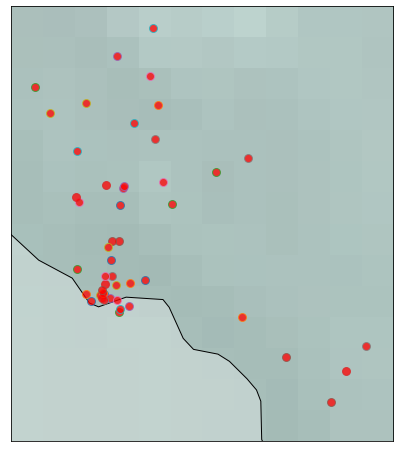

In [14]:
# Display all points on basemap in ramdom colors just to see the geographical distribution. No clustering yet
rcParams['figure.figsize'] = (10,8)

llon=-79.25
ulon=-79.8
llat=43.5
ulat=43.95

my_map = Basemap(projection='lcc',
            resolution = 'h', area_thresh = 0.2, lon_0=longitude, lat_0=latitude,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawstates()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To collect data based on stations        

xs,ys = my_map(np.asarray(cleaned_venue_dataset.lng),np.asarray(cleaned_venue_dataset.lat))
cleaned_venue_dataset['xm']= xs.tolist()
cleaned_venue_dataset['ym'] =ys.tolist()

#Visualization1
for index,row in cleaned_venue_dataset.iterrows():
   my_map.plot(row.xm, row.ym,markerfacecolor ='red',  marker='o', markersize= 8, alpha = 0.75) # ([1,0,0])
plt.show()

### We have used DBSCAN to create clusters of the sports facilities and showed them on a basemap in different colors.

In [15]:
#cleaned_venue_dataset = cleaned_venue_dataset.drop(['Clus_Db'], axis=1)
Clus_dataSet = cleaned_venue_dataset[['lat','lng','category_Baseball Field','category_College Gym','category_Community Center',
                                      'category_Golf Course','category_Gym','category_Gym / Fitness Center','category_Park','category_Plaza',
                                     'category_Tennis Court', 'category_Trail']] # ,'category'
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=2, min_samples=5).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
cleaned_venue_dataset["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 

print('real cluster num (exclude outliers cluster) = ', realClusterNum)
print('Actual total clusters = clusterNum = ', clusterNum)

# A sample of clusters
cleaned_venue_dataset[["venue","lat","lng","userlikes","Clus_Db"]].head(5) # "category"

real cluster num (exclude outliers cluster) =  3
Actual total clusters = clusterNum =  4


,venue,lat,lng,userlikes,Clus_Db
0,Nathan Phillips Square,43.652270,-79.383516,29,-1
1,Christie Pits Park,43.664177,-79.420466,100,0
2,Downsview Park,43.745867,-79.480454,24,0
3,YMCA,43.662753,-79.384849,1,1
4,LA Fitness,43.762424,-79.410793,118,2


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


Cluster 0, category
Cluster 1, category
Cluster 2, category


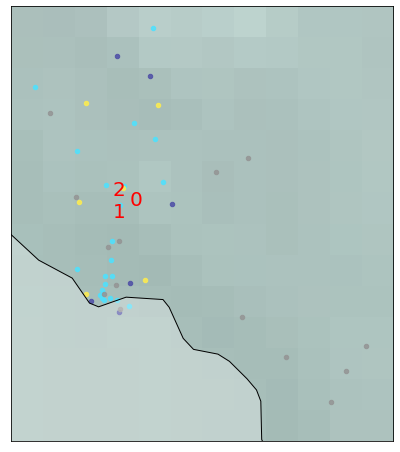

In [16]:
my_map1 = Basemap(projection='lcc',
            resolution = 'h', area_thresh = 0.2, lon_0=longitude, lat_0=latitude,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map1.drawcoastlines()
my_map1.drawcountries()
my_map1.drawstates()
my_map1.fillcontinents(color = 'white', alpha = 0.3)
my_map1.shadedrelief()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))

#Visualization1
for clust_number in set(labels):
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[np.int(clust_number)])
    clust_set = cleaned_venue_dataset[cleaned_venue_dataset.Clus_Db == clust_number]                    
    my_map1.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s=20, alpha = 0.85) # fit in s=clust_set.userlikes
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=20, color='red',)
        print ("Cluster "+ str(clust_number) + ", category")

### Now finally we will extract the outliers from our DBSCAN cluster model which show us the sports facilities which are not near ost other facilities and also their category and user likes. We have found 14 such facilities.

In [17]:
outlier_dataset = cleaned_venue_dataset[cleaned_venue_dataset.Clus_Db == -1]
print("Sparsely located sports facilities size = " ,outlier_dataset.shape)
outlier_dataset_info = outlier_dataset.loc[:,['venueid','venue','distance','category','userlikes','lat','lng']]
outlier_dataset_info.columns = ['Venue ID', 'Sports facility', 'Distance from area centre', 'Category','Likes','Latitude','Longitude']
outlier_dataset_info.reset_index(inplace=True)
outlier_dataset_info = outlier_dataset_info.drop(['index'], axis=1)
outlier_dataset_info.head(15)

Sparsely located sports facilities size =  (14, 21)


,Venue ID,Sports facility,Distance from area centre,Category,Likes,Latitude,Longitude
0,4ad4c05ef964a520a6f620e3,Nathan Phillips Square,657,Plaza,29,43.652270,-79.383516
1,4f554fcae4b02285fd5d4113,Life Time Athletic,29504,Gym,26,43.540220,-79.707374
2,4bcf38879854d13a7da3f54d,Eglinton Park,5986,Baseball Field,191,43.707430,-79.405359
3,4bce3efa68f976b0f6c56583,Milliken Mills Community Centre,21200,Community Center,174,43.840026,-79.305273
4,5776dfbf498ecadab3ba49e1,Life Time Athletic,18972,College Gym,8,43.779179,-79.543572
5,505b8b544c7fd4d07eae01c9,GoodLife Fitness Mississauga Millcreek,31310,Gym,153,43.598008,-79.758831
6,4ae8c418f964a52019b221e3,Athletic Centre,1846,College Gym,191,43.662487,-79.400657
7,4bd4846a6798ef3bd0c5618d,Donalda Golf & Country Club,11039,Golf Course,82,43.752816,-79.342741
8,4b0d7c64f964a520644923e3,YMCA Mississauga,22762,College Gym,104,43.586857,-79.644184
9,4bae4359f964a520539a3be3,Davisville Tennis Club,4939,Tennis Court,144,43.700983,-79.388556


#### Below we have plotted the sparsely located sports facilities around Ryerson,Garden District on a basemap. This makes it easy for the data scientist to suggest the most suitable locations around Ryerson Garden District and the type of sports facility which will be most welcomefor the people living there. This will boost the interested parties business.

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


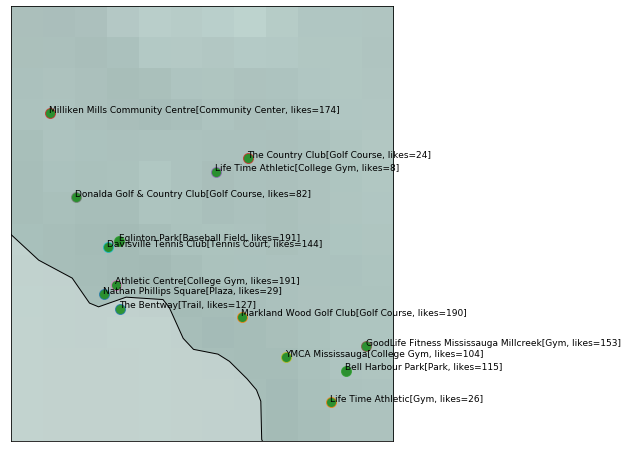

In [18]:
my_map2 = Basemap(projection='lcc',
            resolution = 'h', area_thresh = 0.2, lon_0=longitude, lat_0=latitude,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map2.drawcoastlines()
my_map2.drawcountries()
my_map2.drawstates()
my_map2.fillcontinents(color = 'white', alpha = 0.3)
my_map2.shadedrelief()

#Visualization1
for index,row in outlier_dataset.iterrows():
   x,y = my_map(row.lng, row.lat)
   my_map.plot(row.xm, row.ym,markerfacecolor ='green',  marker='o', markersize= 10, alpha = 0.75) # ([1,0,0])
   outlier_label = row.venue + "[" + row.category + ", likes=" + str(row.userlikes) + "]"
   plt.text(x+100,y+150,outlier_label,fontsize=9)
plt.show()

### Conclusion : Clustering of venues based on their location and category
<div id="clustering">
To conclude regarding the model above, looking at the sparse facility data frame and the map plotted above it seems it would be a good idea to build following kind of new facilitites :
    <ul>
        <li><b>Life Time Athletic Gym</b> near Eglinton Park(43.707430	-79.405359) or Markland Wood Golf Club(43.629057	-79.581131)</li>
        <li><b>Baseball or Tennis facility</b> near YMCA Mississauga(43.586857	-79.644184) or The Country Club(43.793174	-79.589762)</li>
    </ul>
</div>